---
# <span style="color:blue">**Dimensionality Reduction & Feature selection**</span>
---

In this notebook, a dimensionality reduction (PCA) and a feature selection (SelectKBest) algorithm is explored in order to decide for a potential reduction of the features, since after preprocessing<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) there will be more than 100. For both models, the features are scaled with the two scalers explored in the EDA (Min-Max and Standard) and the classifier used is the Random Forest. In order to find the optimal principal components the proportion of variance explained is used, while for the best selected features according to the k highest scores a grid search is perfomed. 

The dataset is initially split into 70-30 for training and testing (here, the test set is not used). Consecutively, the training set is split into 60-40 over 10 different random states for training and validation. In section 1, the classifier is fit on the initial features without reducing them for comparison.  

---
###### <a name="cite_note-1"></a>1. [^](#cite_ref-1) The preprocessing step is the final one that was decided in the previous notebook (03_Tests_over_EDA).

---

In [1]:
import os
import pandas as pd
import utils.preprocess as pre
import utils.testing as testing

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

---
#### **Load data and split for train and test sets**
---

In [2]:
# Read reduced data with corrected labels
data_df = pd.read_csv(os.path.join('data', 'ioT_data_reduced_labels_corrected.csv'))

from sklearn.model_selection import train_test_split

# Split data to X, y
X = data_df.drop(['label', 'detailed_label'], axis=1)
y = data_df['detailed_label'].replace({'-': 0,
                                       'PartOfAHorizontalPortScan':1, 
                                       'C&C' : 2,
                                       'DDoS': 3,
                                       'Attack':4,
                                       'PartOfAVerticalPortScan':5
                                      }).values

# Keep 30% of the data for test
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
print('Train size:', X_tr.shape[0])
print('Test size:', X_te.shape[0])

Train size: 141681
Test size: 60721


---
#### **Define the pipeline**
---

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


# Define the pipeline
pipe = Pipeline([('recover_nulls', pre.RecoverNansPreprocessor()),
                 ('cleaning_preprocessor', pre.CleaningPreprocessor()), 
                 ('categorical_preprocessor', pre.CategoricalPreprocessor(cols_to_dummies = ['protocol', 'conn_state', 'history'])),
                 ('ip_encoding', pre.IPEncodingPreprocessor(ip_to_octets = True)),
                 ('scaler', None),
                 ('ft', None),
                 ('clf', None)

])

# Define the classifier
rf_clf = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', 
                                max_features=None, bootstrap=False, random_state=0)

---
### **1. Fit without selecting features or reducing dimensions**
---

In [4]:
# Set the classifier
pipe.set_params(clf=rf_clf)

# Fit the classfier
gs_results_test_1 = testing.fit_pipe_single_splitting(X_tr, y_tr, pipe)

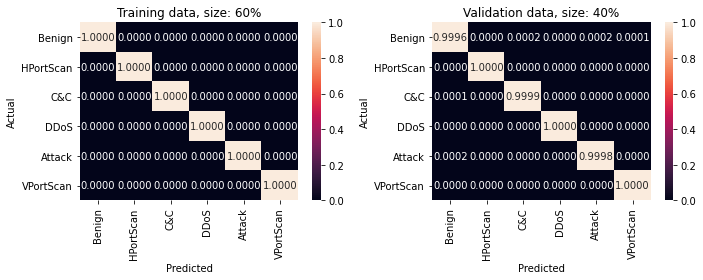

,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std
0,1.0,0.0,0.999938,0.000028


In [5]:
# Show results
gs_results_test_1_avg = testing.average_results_single_splitting(gs_results_test_1)

> By using all features, the Random Forest Classifier has an excellent performance of distinguishing all traffic flows with only a few misclassification for the benign, C&C and Attack.

---
### **2. PCA**
---

#### **2.1. With StandardScaler**
---

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pipe.set_params(clf=None)
pipe.set_params(scaler=StandardScaler())
pipe.set_params(ft=PCA(n_components=None, random_state=0))

# Apply PCA on training features
pipe.fit(X_tr)

# Get Proportion of variance explained
pve = pipe.named_steps['ft'].explained_variance_ratio_

# Print number of samples, features and components
print('PCA n_samples:', pipe.named_steps['ft'].n_samples_)
print('PCA n_features:', pipe.named_steps['ft'].n_features_)
print('PCA n_components:', pipe.named_steps['ft'].n_components_)

PCA n_samples: 141681
PCA n_features: 124
PCA n_components: 124


---
##### **2.1.1 Scree Plots**
---

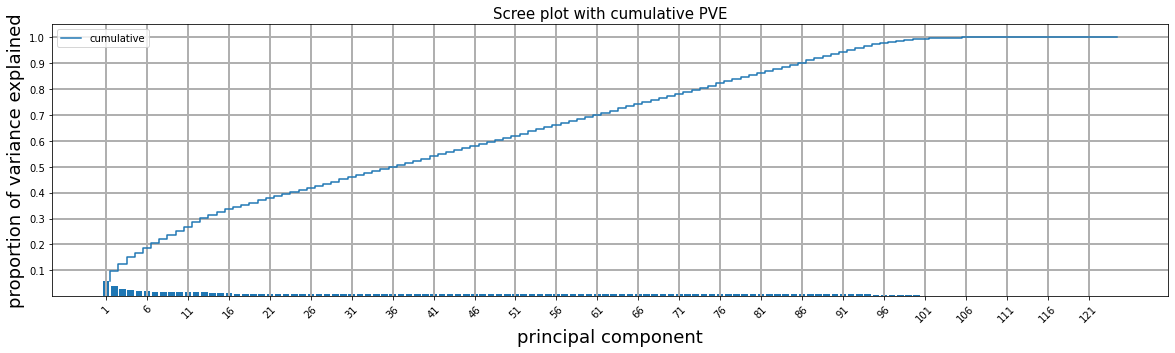

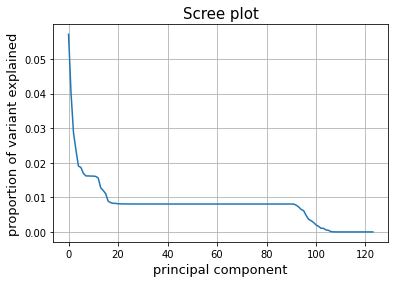

In [7]:
# Plot PVE
testing.plot_pve(pve, pipe)

> With the Standard Scaler we see that there are 2 different pronounced drop offs with <10 principal components and around 20 explaining only ~10% and 30% respectively of the variance in the data set. With 20 up to ~90 principal components the pve is the same while the cumulative reaches about ~95% with ~95 principal components.

---
##### **2.1.2 Plot 2 first principal components**
---

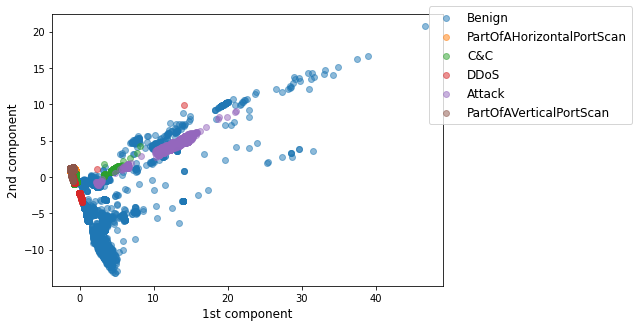

In [8]:
testing.plot_2_pp(X_tr, y_tr, pipe)

> Since with only the first two principal components the cumulative proportion of variance explained is less than 10% with the Standard scaler, we see that the benign traffic is not distinguishable from the malicious. In addition, we see that the scaling of the principal components is not the same as expected. 

---
##### **2.1.3 Fit the classifier**
---

In [10]:
# Silent DataConversionWarning (Standard Scaler needs all features to be floats)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Define number of components
pca_n_comp_ss = 95
pipe.set_params(ft__n_components=pca_n_comp_ss)
# Add classifier
pipe.set_params(clf=rf_clf)

# Fit and get results
gs_results_test_2_1 = testing.fit_pipe_single_splitting(X_tr, y_tr, pipe)

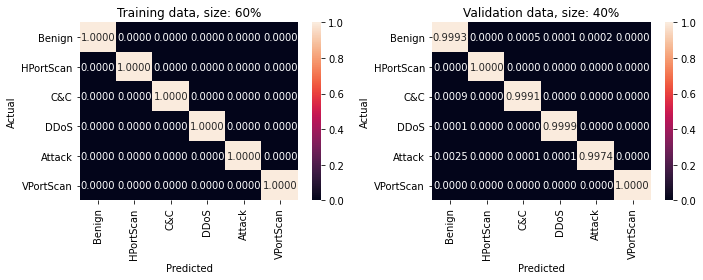

,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std
0,1.0,0.0,0.999765,0.000089


In [11]:
# Show results
gs_results_test_2_1_avg = testing.average_results_single_splitting(gs_results_test_2_1)

> With 95 principal components, the performance of the Random Forest classifier is about the same as by using all features. 

---
#### **2.2. With MixMaxScaler**
---

In [12]:
from sklearn.preprocessing import MinMaxScaler

pipe.set_params(clf=None)
pipe.set_params(scaler=MinMaxScaler())
pipe.set_params(ft=PCA(n_components=None, random_state=0))


# Apply PCA on training features
pipe.fit(X_tr)

# Get Proportion of variance explained
pve = pipe.named_steps['ft'].explained_variance_ratio_

---
##### **2.2.1 Scree Plots**
---

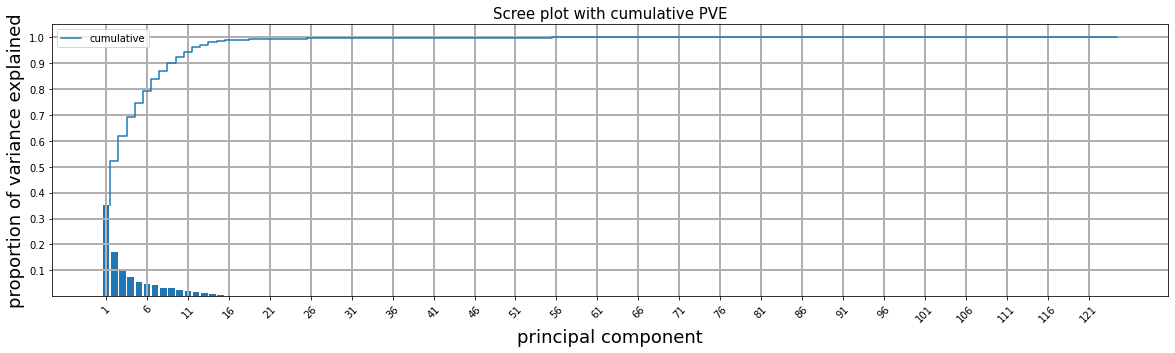

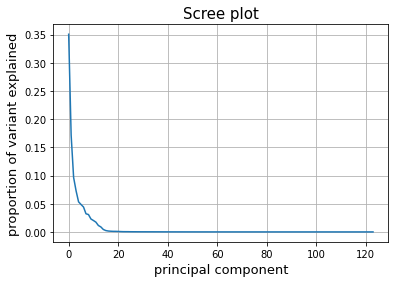

In [13]:
# Plot PVE
testing.plot_pve(pve, pipe)

> By using the MinMaxScaler with only ~16 components we have about ~98% of the variance in the data explained.

---
##### **2.2.2 Plot 2 first principal components**
---

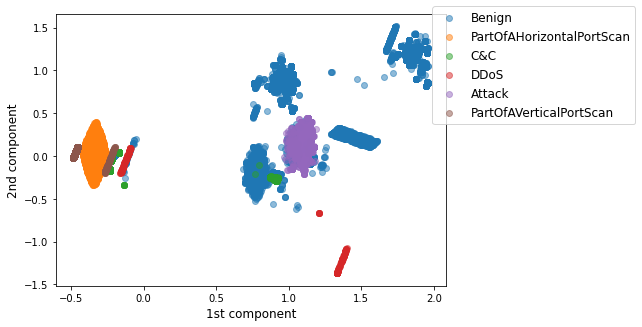

In [14]:
testing.plot_2_pp(X_tr, y_tr, pipe)

> With already 2 principal components, we see that there are clusters of benign entries and about half of the DDoS entries that are quite distinguishable from the other classes.

---
##### **2.2.3 Fit the classifier**
---

In [16]:
# Change number of components
pca_n_comp_mm = 16
pipe.set_params(ft__n_components=pca_n_comp_mm)
# Add classifier
pipe.set_params(clf=rf_clf)

# Fit and get results
gs_results_test_2_2 = testing.fit_pipe_single_splitting(X_tr, y_tr, pipe)

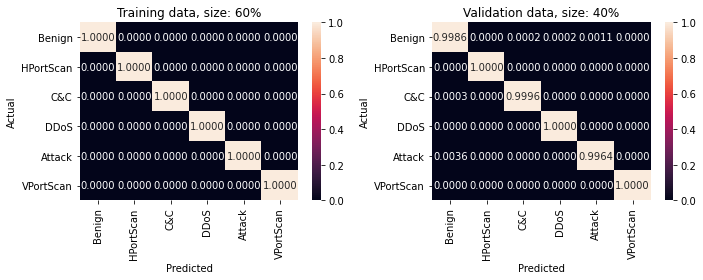

,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std
0,1.0,0.0,0.999721,0.000062


In [17]:
# Show results
gs_results_test_2_2_avg = testing.average_results_single_splitting(gs_results_test_2_2)

> With 16 principal components, the performance of the Random Forest classifier is about the same as by using all features. 

---
### **3. SelectKBest**
---

---
#### **3.1 Grid search for best number of top features**
---

In [18]:
from sklearn.feature_selection import SelectKBest

pipe.set_params(scaler=None)
pipe.set_params(ft=SelectKBest())
pipe.set_params(clf=rf_clf)

# Fit and get results
gs_results_test_3 = testing.fit_pipe_SelectKBest(X_tr, y_tr, pipe)

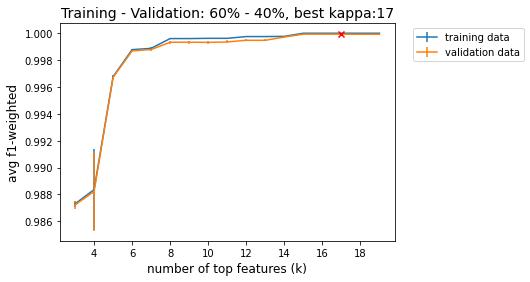

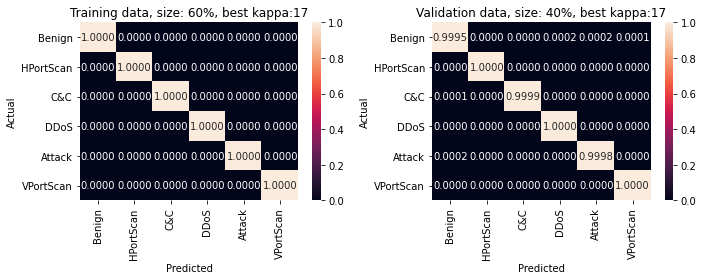

,k,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std
14,17,1.0,0.0,0.999931,0.000018


In [19]:
# Average results and plot
gs_results_test_3_avg = testing.average_results_SelectKBest(gs_results_test_3)

> With the grid search we see that the best averaged f1-score is achieved by selecting 17 features.

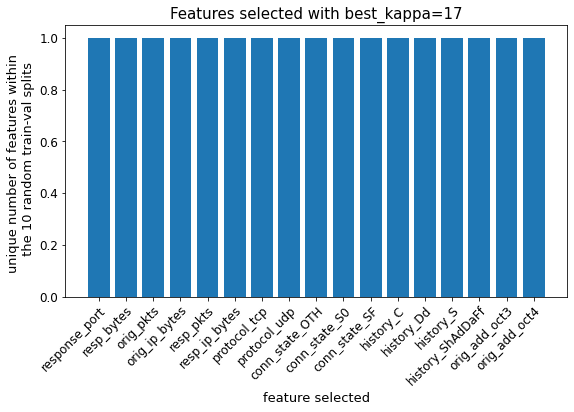

In [20]:
# Check features selected for the different random states of splitting for the best kappa
import numpy as np
from itertools import compress

df = gs_results_test_3.loc[gs_results_test_3['k']==17][['features']]
df = df[['features']].unstack().apply(pd.Series).reset_index().T
df = df.drop([df.index[0] , df.index[1]])
df['n_uniques'] = df.nunique(axis=1)

# get mask with duplicated values and remove n_uniques
mask = df.T.duplicated().to_list()
mask.pop()

# get column names in list and remove n_uniques
cols = df.columns.to_list()
cols.pop()

# apply reverse mask on duplicates and find column name
res = list(compress(cols, ~np.array(mask)))

#plot
plt.figure(figsize=(9,5))
plt.bar(df[res[0]], df['n_uniques'])
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('feature selected', fontsize=13)
plt.ylabel('unique number of features within \n the 10 random train-val splits', fontsize=13)
plt.title('Features selected with best_kappa=17', fontsize=15)
plt.show()

> Among the top 17 features that were selected we see that:
> - 4 of them correspond to the responder (port, bytes, ip_bytes and packets)
> - 4 of them correspond to the originator (packets, ip_bytes, origin_address octets 3 and 4)
> - 2 of them correspond to the protocol (TCP and UDP)
> - 3 of them correspond to the connection state (OTH, S0 and SF)
> - 4 of them correspond to the history

---
#### **3.2 Fit best Kappa with a MinMaxScaler**
---

In [21]:
pipe.set_params(scaler=MinMaxScaler())
pipe.set_params(ft__k=17)


# Fit and get results
gs_results_test_3_2 = testing.fit_pipe_single_splitting(X_tr, y_tr, pipe)

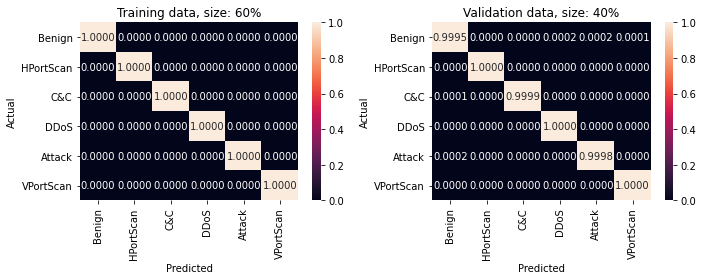

,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std
0,1.0,0.0,0.999931,0.000018


In [22]:
# Show results
gs_results_test_3_2_avg = testing.average_results_single_splitting(gs_results_test_3_2)

> From the results above, we see that either scaling the features with the MixMaxScaler (prior using the SelectKBest) or not, the results are the same.

---
#### **3.3 Fit best Kappa with a StandardScaler**
---

In [23]:
pipe.set_params(scaler=StandardScaler())

# Fit and get results
gs_results_test_3_3 = testing.fit_pipe_single_splitting(X_tr, y_tr, pipe)

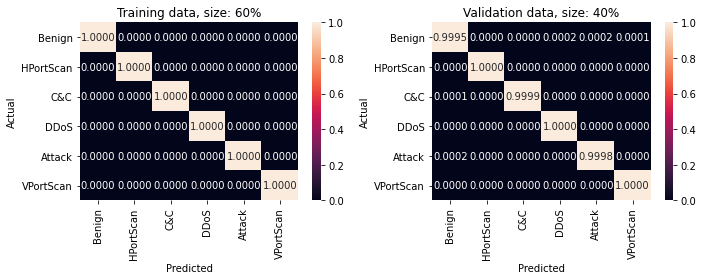

,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std
0,1.0,0.0,0.999931,0.000018


In [24]:
# Show results
gs_results_test_3_3_avg = testing.average_results_single_splitting(gs_results_test_3_3)

> Also with the Standard scaler, we see that the scaling does not affect the results. 

---
### **4. Compare results**
---

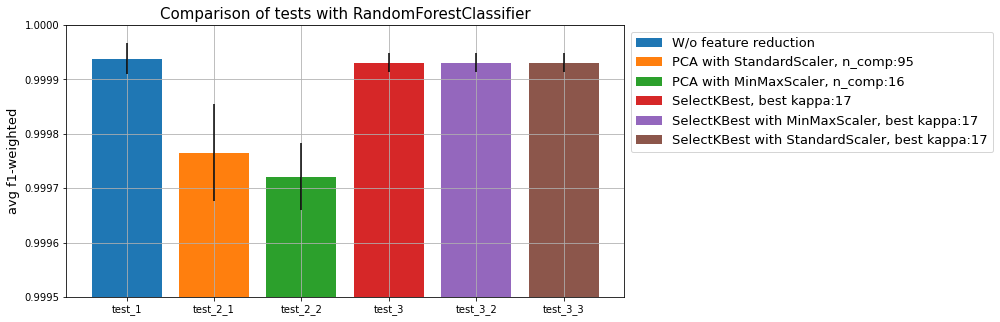

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))

best_kappa = gs_results_test_3_avg['k'].values[0]

plt.bar('test_1', gs_results_test_1_avg['f1_val_mean'].values[0], 
             yerr=gs_results_test_1_avg['f1_val_std'].values[0], color='tab:blue', 
             label='W/o feature reduction')

plt.bar('test_2_1', gs_results_test_2_1_avg['f1_val_mean'].values[0], 
               yerr=gs_results_test_2_1_avg['f1_val_std'].values[0], color='tab:orange', 
               label='PCA with StandardScaler, n_comp:{:.0f}'.format(pca_n_comp_ss))

plt.bar('test_2_2', gs_results_test_2_2_avg['f1_val_mean'].values[0], 
               yerr=gs_results_test_2_2_avg['f1_val_std'].values[0], color='tab:green',
               label='PCA with MinMaxScaler, n_comp:{:.0f}'.format(pca_n_comp_mm))

plt.bar('test_3', gs_results_test_3_avg['f1_val_mean'].values[0], 
             yerr=gs_results_test_3_avg['f1_val_std'].values[0], color='tab:red', 
             label='SelectKBest, best kappa:{:.0f}'.format(best_kappa))

plt.bar('test_3_2', gs_results_test_3_2_avg['f1_val_mean'].values[0], 
               yerr=gs_results_test_3_2_avg['f1_val_std'].values[0], color='tab:purple', 
               label='SelectKBest with MinMaxScaler, best kappa:{:.0f}'.format(best_kappa))

plt.bar('test_3_3', gs_results_test_3_3_avg['f1_val_mean'].values[0], 
               yerr=gs_results_test_3_3_avg['f1_val_std'].values[0], color='tab:brown', 
               label='SelectKBest with StandardScaler, best kappa:{:.0f}'.format(best_kappa))

plt.title('Comparison of tests with RandomForestClassifier', fontsize=15)
plt.ylabel('avg f1-weighted', fontsize=13)
plt.legend(bbox_to_anchor=(1, 1), fontsize=13)
plt.ylim(0.9995,1)
plt.grid()
plt.show()

> The difference between the dimensionality reduction and the feature selection is subtle. However, the **SelectKBest** with 17 top features will be used in the final preprocessing step. 